In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import eli5
import xarray as xr
from eli5.sklearn import PermutationImportance
import os
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cdo


In [123]:
file1 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test1.csv'
file2 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test2.csv'
file3 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test3.csv'
file4 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test4.csv'


In [124]:
file_list=[file1,file2,file3,file4]
  
dataset = pd.DataFrame(pd.read_csv(file_list[0]))
  
for i in range(1,len(file_list)):
    data = pd.read_csv(file_list[i])
    df = pd.DataFrame(data)
    dataset = pd.concat([dataset,df])

In [125]:
dataset.head()

,hotel_id,price,stock,city,date,language,mobile,avatar_id,group,brand,parking,pool,children_policy
0,918,336,23,amsterdam,14,dutch,0,59852,Morriott International,Corlton,1,1,0
1,442,190,19,amsterdam,14,dutch,0,59852,Accar Hotels,Marcure,0,0,0
2,588,173,0,amsterdam,14,dutch,0,59852,Independant,Independant,0,0,0
3,807,323,17,amsterdam,14,dutch,0,59852,Chillton Worldwide,Chill Garden Inn,0,1,0
4,271,81,0,amsterdam,14,dutch,0,59852,Independant,Independant,1,0,0


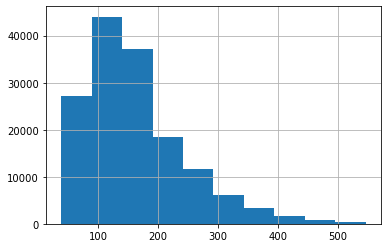

In [126]:
dataset['price'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc96c0274f0>,
      dtype=object)

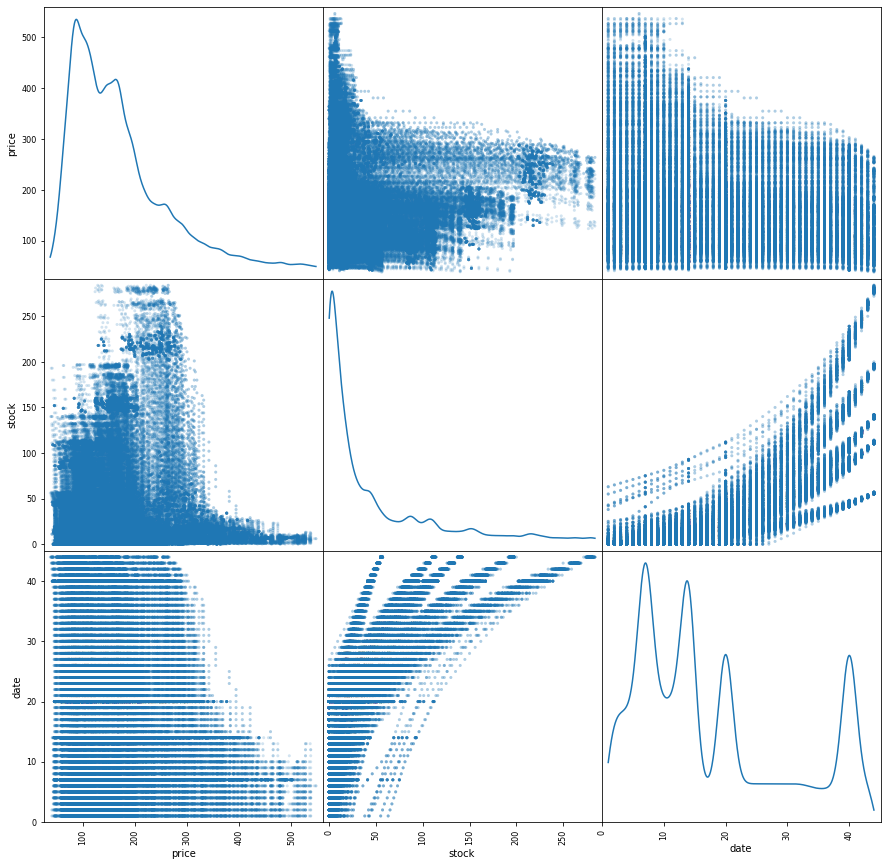

In [127]:
scatter_matrix(dataset[["price","stock","date"]], alpha=0.2, figsize=(15, 15), diagonal='kde')


### Extraction des échantillons apprentissage et test

In [128]:
dataset.dtypes

hotel_id            int64
price               int64
stock               int64
city               object
date                int64
language           object
mobile              int64
avatar_id           int64
group              object
brand              object
parking             int64
pool                int64
children_policy     int64
dtype: object

In [129]:
# Variables explicatives

# A FAIRE : utiliser OneHotEncoder plutôt que dummies

hotel_pricesDum = pd.get_dummies(dataset[["city","language","group","brand"]])
hotel_priceQuant=dataset[["hotel_id","stock","date","mobile","avatar_id","parking","pool","children_policy"]]
df = pd.concat([hotel_pricesDum,hotel_priceQuant],axis=1)
df.head()


,city_amsterdam,city_copenhagen,city_madrid,city_paris,city_rome,city_sofia,city_valletta,city_vienna,city_vilnius,language_austrian,...,brand_Safitel,brand_Tripletree,hotel_id,stock,date,mobile,avatar_id,parking,pool,children_policy
0,1,0,0,0,0,0,0,0,0,0,...,0,0,918,23,14,0,59852,1,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,442,19,14,0,59852,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,588,0,14,0,59852,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,807,17,14,0,59852,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,271,0,14,0,59852,1,0,0


In [130]:
feature_names = list(df.columns.values)

In [131]:
feature_names

['city_amsterdam',
 'city_copenhagen',
 'city_madrid',
 'city_paris',
 'city_rome',
 'city_sofia',
 'city_valletta',
 'city_vienna',
 'city_vilnius',
 'language_austrian',
 'language_belgian',
 'language_bulgarian',
 'language_croatian',
 'language_cypriot',
 'language_czech',
 'language_danish',
 'language_dutch',
 'language_estonian',
 'language_finnish',
 'language_french',
 'language_german',
 'language_greek',
 'language_hungarian',
 'language_irish',
 'language_italian',
 'language_latvian',
 'language_lithuanian',
 'language_luxembourgish',
 'language_maltese',
 'language_polish',
 'language_portuguese',
 'language_romanian',
 'language_slovakian',
 'language_slovene',
 'language_spanish',
 'language_swedish',
 'group_Accar Hotels',
 'group_Boss Western',
 'group_Chillton Worldwide',
 'group_Independant',
 'group_Morriott International',
 'group_Yin Yang',
 'brand_8 Premium',
 'brand_Ardisson',
 'brand_Boss Western',
 'brand_Chill Garden Inn',
 'brand_Corlton',
 'brand_CourtYord

In [132]:
# variable à expliquer
Yr=dataset["price"]

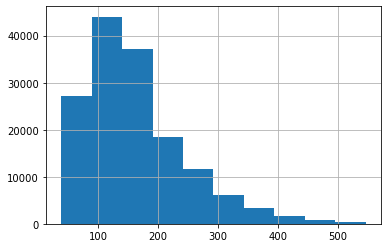

In [133]:
Yr.hist()

In [66]:
# from sklearn.preprocessing import StandardScaler  
# # L'algorithme ds réseaux de neurones nécessite éventuellement une normalisation 
# # des variables explicatives avec les commandes ci-dessous
# scaler = StandardScaler()  
# scaler.fit(X_train)  
# Xr_train = scaler.transform(X_train)  

# Xr_test = scaler.transform(X_test)

### Forêts aléatoires

In [105]:
from sklearn.model_selection import train_test_split  
X_train,X_test,Yr_train,Yr_test=train_test_split(df,Yr,test_size=0.1)

In [106]:
rf = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(max_depth=10),
)
rf.fit(X_train, Yr_train)
print(f"Random forest score: {rf.score(X_test, Yr_test):.2f}")

Random forest score: 0.89


### Importance des features

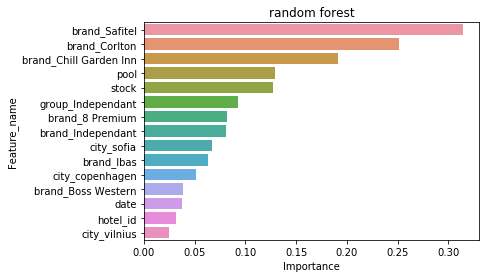

In [15]:
import seaborn as sns

features_importance_dict = {}
for model, name in zip([rf], ['random forest']):
    plt.figure()
    permumtation_impor = PermutationImportance(model, random_state=0).fit(X_test, Yr_test)
    features_importance = {'Feature_name':feature_names, 'Importance':permumtation_impor.feature_importances_}  
    features_importance = pd.DataFrame(features_importance) 
    features_importance = features_importance.sort_values(['Importance'], ascending=False) 
    features_importance_dict[name] = features_importance
    ax = sns.barplot(x="Importance", y="Feature_name", data=features_importance[0:15])
    plt.title(name)

In [16]:
features_importance

,Feature_name,Importance
56,brand_Safitel,3.141463e-01
46,brand_Corlton,2.511047e-01
45,brand_Chill Garden Inn,1.910425e-01
64,pool,1.292052e-01
59,stock,1.267515e-01
...,...,...
14,language_czech,-1.023385e-07
20,language_german,-1.430759e-07
33,language_slovene,-5.307832e-07
29,language_polish,-1.397434e-06


In [17]:
Feature_name = features_importance['Feature_name'].tolist()
Importance = features_importance['Importance'].tolist()

Feature_name2 = ['city','language', 'group','brand','hotel_id','stock','date','mobile','avatar_id','parking','pool','children_policy']
Importance2 = [0 for i in range(len(Feature_name2))]

for i in range(len(Feature_name)):
    if Feature_name[i][0:4]=='city':
        Importance2[0]=Importance2[0]+Importance[i]
    
    if Feature_name[i][0:8]=='language':
        Importance2[1]=Importance2[1]+Importance[i]  
   
    if Feature_name[i][0:5]=='group':
        Importance2[2]=Importance2[2]+Importance[i]  
        
    if Feature_name[i][0:5]=='brand':
        Importance2[3]=Importance2[3]+Importance[i]  

for j in range(4,len(Feature_name2)):
    Importance2[j]= Importance[Feature_name.index(Feature_name2[j])]     
        
Importance2      
features_importance2 = pd.DataFrame(list(zip(Feature_name2, Importance2)),columns =['Feature_name2', 'Importance2'])
features_importance2


,Feature_name2,Importance2
0,city,1.777810e-01
1,language,3.173907e-04
2,group,9.383142e-02
3,brand,1.041519e+00
4,hotel_id,3.178869e-02
5,stock,1.267515e-01
6,date,3.790517e-02
7,mobile,7.962346e-07
8,avatar_id,3.222678e-04
9,parking,6.023625e-03


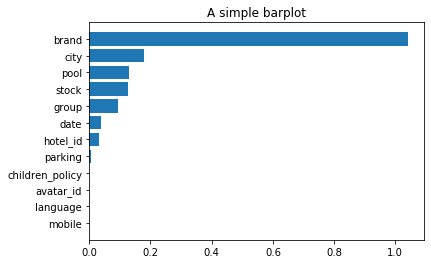

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a data frame
df = pd.DataFrame ({
        'Group':  features_importance2['Feature_name2'],
        'Value': features_importance2['Importance2']
})

# Sort the table
df = df.sort_values(by=['Value'])

# Create horizontal bars
plt.barh(y=df.Group, width=df.Value);

# Add title
plt.title('A simple barplot');

On refait un random forest en retirant les features peu importantes

In [134]:
df2 = df

In [135]:
del df2['parking']
del df2['children_policy']
del df2['mobile']
del df2['avatar_id']
del df2['language_austrian']
del df2['language_belgian']
del df2['language_bulgarian']
del df2['language_croatian']
del df2['language_cypriot']
del df2['language_czech']
del df2['language_danish']
del df2['language_dutch']
del df2['language_estonian']
del df2['language_finnish']
del df2['language_french']
del df2['language_german']
del df2['language_greek']
del df2['language_hungarian']
del df2['language_irish']
del df2['language_italian']
del df2['language_latvian']
del df2['language_lithuanian']
del df2['language_luxembourgish']
del df2['language_maltese']
del df2['language_polish']
del df2['language_portuguese']
del df2['language_romanian']
del df2['language_slovakian']
del df2['language_slovene']
del df2['language_spanish']
del df2['language_swedish']

In [136]:
from sklearn.model_selection import train_test_split  
X_train,X_test,Yr_train,Yr_test=train_test_split(df2,Yr,test_size=0.1)

In [137]:
rf =  RandomForestRegressor()
rf.fit(X_train, Yr_train)
print(f"Random forest2 score: {rf.score(X_test, Yr_test):.2f}")

Random forest2 score: 1.00


## Tester le même modèle en changeant la façon d'encoder les variables

### XGBoost

In [ ]:
X_train,X_test,Yr_train,Yr_test=train_test_split(df,Yr,test_size=0.1)

In [70]:
import xgboost as xgb

clf = xgb.XGBRegressor()
clf.fit(X_train, Yr_train)
print(f"XGBoost score: {clf.score(X_test, Yr_test):.2f}")

XGBoost score: 0.98


On refait la même chose avec un tableau sans les features peu importn=antes

In [ ]:
X_train,X_test,Yr_train,Yr_test=train_test_split(df2,Yr,test_size=0.1)

In [87]:
clf = xgb.XGBRegressor()
clf.fit(X_train, Yr_train)
print(f"XGBoost score2: {clf.score(X_test, Yr_test):.2f}")

,city_amsterdam,city_copenhagen,city_madrid,city_paris,city_rome,city_sofia,city_valletta,city_vienna,city_vilnius,group_Accar Hotels,...,brand_Morriot,brand_Navatel,brand_Quadrupletree,brand_Royal Lotus,brand_Safitel,brand_Tripletree,hotel_id,stock,date,pool
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,918,23,14,1
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,442,19,14,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,588,0,14,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,807,17,14,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,271,0,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38857,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,272,0,7,0
38858,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,353,13,7,0
38859,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,304,19,7,0
38860,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,145,7,7,0
